In [ ]:
!pip install -U datasets
!pip install -U pytorch_msssim
!pip install scikit-learn

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Optional
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import transforms
import os

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm import tqdm
import traceback

from scipy import stats
from pytorch_msssim import ms_ssim

import torch.optim as optim
import json
from datetime import datetime
import gc
import wandb
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

In [32]:
class AttentionBlock(nn.Module):
    """Self-attention block dla encodera"""
    def __init__(self, channels: int):
        super().__init__()
        self.channels = channels
        self.norm = nn.GroupNorm(32, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        h = self.norm(x)
        q = self.q(h)
        k = self.k(h)
        v = self.v(h)

        b, c, h, w = q.shape
        q = q.reshape(b, c, h * w).permute(0, 2, 1)
        k = k.reshape(b, c, h * w)
        v = v.reshape(b, c, h * w).permute(0, 2, 1)

        attn = torch.bmm(q, k) * (c ** -0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(attn, v)
        out = out.permute(0, 2, 1).reshape(b, c, h, w)
        out = self.proj_out(out)

        return x + out

class ResidualBlock(nn.Module):
    """Blok residualny dla encodera i decodera"""
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(32, in_channels)
        self.norm2 = nn.GroupNorm(32, out_channels)

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        shortcut = self.shortcut(x)

        x = self.norm1(x)
        x = F.silu(x)
        x = self.conv1(x)

        x = self.norm2(x)
        x = F.silu(x)
        x = self.conv2(x)

        return x + shortcut

class Encoder(nn.Module):
    """Encoder VAE z opcjonalnymi blokami attention"""
    def __init__(self, latent_dim: int = 64, use_attention: bool = False):
        super().__init__()
        self.use_attention = use_attention

        self.conv_in = nn.Conv2d(3, 128, 3, padding=1)

        self.down_blocks = nn.ModuleList([
            # 256x256 -> 128x128
            nn.Sequential(
                ResidualBlock(128, 128),
                ResidualBlock(128, 128),
                nn.Conv2d(128, 128, 3, stride=2, padding=1)
            ),
            # 128x128 -> 64x64
            nn.Sequential(
                ResidualBlock(128, 256),
                ResidualBlock(256, 256),
                nn.Conv2d(256, 256, 3, stride=2, padding=1)
            ),
            # 64x64 -> 32x32
            nn.Sequential(
                ResidualBlock(256, 512),
                ResidualBlock(512, 512),
                nn.Conv2d(512, 512, 3, stride=2, padding=1)
            ),
            # 32x32 -> 16x16
            nn.Sequential(
                ResidualBlock(512, 512),
                ResidualBlock(512, 512),
                nn.Conv2d(512, 512, 3, stride=2, padding=1)
            )
        ])

        if self.use_attention:
            self.attention_blocks = nn.ModuleList([
                None,
                None,
                AttentionBlock(512),
                AttentionBlock(512)
            ])

        self.mid_block = nn.Sequential(
            ResidualBlock(512, 512),
            AttentionBlock(512) if use_attention else nn.Identity(),
            ResidualBlock(512, 512)
        )

        self.norm_out = nn.GroupNorm(32, 512)
        self.conv_out = nn.Conv2d(512, latent_dim * 2, 3, padding=1)

    def forward(self, x):
        x = self.conv_in(x)

        for i, down_block in enumerate(self.down_blocks):
            x = down_block(x)
            if self.use_attention and self.attention_blocks[i] is not None:
                x = self.attention_blocks[i](x)

        x = self.mid_block(x)

        x = self.norm_out(x)
        x = F.silu(x)
        x = self.conv_out(x)
        return x

class Decoder(nn.Module):
    """Decoder VAE z warstwami normalizującymi"""
    def __init__(self, latent_dim: int = 64):
        super().__init__()

        self.conv_in = nn.Conv2d(latent_dim, 512, 3, padding=1)

        self.mid_block = nn.Sequential(
            ResidualBlock(512, 512),
            ResidualBlock(512, 512)
        )

        self.up_blocks = nn.ModuleList([
            # 16x16 -> 32x32
            nn.Sequential(
                ResidualBlock(512, 512),
                ResidualBlock(512, 512),
                nn.GroupNorm(32, 512),
                nn.SiLU(),
                nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
            ),
            # 32x32 -> 64x64
            nn.Sequential(
                ResidualBlock(512, 256),
                ResidualBlock(256, 256),
                nn.GroupNorm(32, 256),
                nn.SiLU(),
                nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
            ),
            # 64x64 -> 128x128
            nn.Sequential(
                ResidualBlock(256, 128),
                ResidualBlock(128, 128),
                nn.GroupNorm(32, 128),
                nn.SiLU(),
                nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
            ),
            # 128x128 -> 256x256
            nn.Sequential(
                ResidualBlock(128, 128),
                ResidualBlock(128, 128),
                nn.GroupNorm(32, 128),
                nn.SiLU(),
                nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
            )
        ])

        self.norm_out = nn.GroupNorm(32, 128)
        self.conv_out = nn.Conv2d(128, 3, 3, padding=1)

    def forward(self, z):
        x = self.conv_in(z)
        x = self.mid_block(x)

        for up_block in self.up_blocks:
            for layer in up_block:
                if callable(layer):
                    x = layer(x)
                else:
                    x = layer(x)

        x = self.norm_out(x)
        x = F.silu(x)
        x = self.conv_out(x)
        x = torch.tanh(x)

        return x

class VAE(nn.Module):
    """Kompletny model VAE"""
    def __init__(self, latent_dim: int = 64, use_attention: bool = False):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim, use_attention)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Enkodowanie do przestrzeni latentnej"""
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Dekodowanie z przestrzeni latentnej"""
        return self.decoder(z)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass przez cały VAE"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def sample(self, num_samples: int, device: str = 'cpu') -> torch.Tensor:
        """Generowanie próbek z przestrzeni latentnej"""
        z = torch.randn(num_samples, self.latent_dim, 16, 16, device=device)
        return self.decode(z)

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """Funkcja straty VAE (ELBO)"""
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss


class HuggingFaceImageDataset(Dataset):
    """Dataset wrapper dla Hugging Face dataset z obrazami"""
    def __init__(self, hf_dataset, transform=None, image_column='image'):
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.image_column = image_column

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item[self.image_column]

        if hasattr(image, 'convert'):
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

class ImageDataset(Dataset):
    """Dataset dla obrazów z folderu"""
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = []

        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

        for file in os.listdir(image_dir):
            if file.lower().endswith(valid_extensions):
                self.image_files.append(file)

        print(f"Znaleziono {len(self.image_files)} obrazów")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    return train_transform, val_transform

def save_samples(model, device, epoch, save_dir, num_samples=4):
    """Zapisuje próbki wygenerowane przez model"""
    model.eval()
    with torch.no_grad():
        samples = model.sample(num_samples, device=device)
        samples = (samples + 1) / 2
        samples = samples.cpu()

        fig, axes = plt.subplots(1, num_samples, figsize=(16, 4))
        if num_samples == 1:
            axes = [axes]

        for i in range(num_samples):
            img = samples[i].permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axes[i].imshow(img)
            axes[i].axis('off')

        plt.tight_layout()
        save_path = os.path.join(save_dir, f'samples_epoch_{epoch:03d}.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

        if wandb.run is not None:
            wandb.log({
                "generated_samples": wandb.Image(save_path),
                "epoch": epoch
            })

        plt.close()
        return save_path

def save_reconstructions(model, dataloader, device, epoch, save_dir, num_images=4):
    """Zapisuje rekonstrukcje obrazów"""
    save_path = None
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            if len(batch) >= num_images:
                originals = batch[:num_images].to(device)
                reconstructions, mu, logvar = model(originals)

                originals = (originals + 1) / 2
                reconstructions = (reconstructions + 1) / 2

                fig, axes = plt.subplots(2, num_images, figsize=(16, 8))

                for i in range(num_images):
                    orig_img = originals[i].cpu().permute(1, 2, 0).numpy()
                    orig_img = np.clip(orig_img, 0, 1)
                    axes[0, i].imshow(orig_img)
                    axes[0, i].set_title('Original')
                    axes[0, i].axis('off')

                    recon_img = reconstructions[i].cpu().permute(1, 2, 0).numpy()
                    recon_img = np.clip(recon_img, 0, 1)
                    axes[1, i].imshow(recon_img)
                    axes[1, i].set_title('Reconstruction')
                    axes[1, i].axis('off')

                plt.tight_layout()
                save_path = os.path.join(save_dir, f'reconstructions_epoch_{epoch:03d}.png')
                plt.savefig(save_path, dpi=150, bbox_inches='tight')

                if wandb.run is not None:
                    wandb.log({
                        "reconstructions": wandb.Image(save_path),
                        "epoch": epoch
                    })

                plt.close()
                break

        return save_path

def train_vae(config):
    save_dir = f"vae_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'checkpoints'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'samples'), exist_ok=True)

    if config['use_wandb']:
        run_name = config['run_name'] or f"vae_{datetime.now().strftime('%m%d_%H%M')}"
        wandb.init(
            project=config['project_name'],
            name=run_name,
            config=config,
            tags=config['tags'],
            dir=save_dir
        )

        save_dir = os.path.join(save_dir, wandb.run.id)
        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(os.path.join(save_dir, 'checkpoints'), exist_ok=True)
        os.makedirs(os.path.join(save_dir, 'samples'), exist_ok=True)

    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Używam: {device}")

    model = VAE(latent_dim=config['latent_dim'],
                use_attention=config['use_attention']).to(device)

    print(f"Parametry modelu: {sum(p.numel() for p in model.parameters()):,}")

    if wandb.run is not None:
        wandb.watch(model, log_freq=100, log_graph=True)

    optimizer = optim.AdamW(model.parameters(),
                           lr=config['learning_rate'],
                           weight_decay=1e-4)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=config['num_epochs'])

    scaler = torch.cuda.amp.GradScaler() if config['mixed_precision'] else None

    train_transform, val_transform = get_transforms()

    if config['use_hf_dataset']:
        print(f"Ładuję dataset z Hugging Face: {config['hf_dataset_name']}")
        hf_dataset = load_dataset(config['hf_dataset_name'])

        print("Struktura datasetu:")
        print(hf_dataset)

        train_split = hf_dataset["train"]
        print(f"Liczba przykładów: {len(train_split)}")

        first_example = train_split[0]
        print("Kolumny w datasecie:", list(first_example.keys()))

        if config['image_column'] not in first_example:
            print(f"BŁĄD: Kolumna '{config['image_column']}' nie istnieje!")
            print(f"Dostępne kolumny: {list(first_example.keys())}")
            return

        full_dataset = HuggingFaceImageDataset(
            train_split,
            transform=train_transform,
            image_column=config['image_column']
        )

    else:
        if config['local_image_dir'] is None:
            print("BŁĄD: Podaj ścieżkę do folderu z obrazami w 'local_image_dir'")
            return

        full_dataset = ImageDataset(
            config['local_image_dir'],
            transform=train_transform
        )

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size]
    )

    if len(train_dataset) == 0:
        print("Error: Training dataset is empty after split. Cannot create DataLoader.")
        return

    train_loader = DataLoader(train_dataset,
                             batch_size=config['batch_size'],
                             shuffle=True,
                             num_workers=0,
                             pin_memory=False)

    if config['use_hf_dataset']:
        val_full_dataset = HuggingFaceImageDataset(
            train_split,
            transform=val_transform,
            image_column=config['image_column']
        )
        val_indices = val_dataset.indices
        val_dataset_transformed = torch.utils.data.Subset(val_full_dataset, val_indices)
    else:
        val_dataset_transformed = val_dataset

    val_loader = DataLoader(val_dataset_transformed,
                           batch_size=config['batch_size'],
                           shuffle=False,
                           num_workers=0,
                           pin_memory=False)

    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")

    print("Test DataLoader...")
    try:
        test_batch = next(iter(train_loader))
        print(f"Batch shape: {test_batch.shape}")
        print(f"Batch dtype: {test_batch.dtype}")
        print(f"Batch range: [{test_batch.min():.3f}, {test_batch.max():.3f}]")
    except Exception as e:
        print(f"BŁĄD w DataLoader: {e}")
        return

    if wandb.run is not None:
        wandb.log({
            "dataset/train_size": len(train_dataset),
            "dataset/val_size": len(val_dataset),
            "dataset/total_size": len(full_dataset)
        })

    train_losses = []
    val_losses = []

    for epoch in range(config['num_epochs']):
        if epoch < config['beta_warmup_epochs']:
            beta = config['beta'] + (config['beta_max'] - config['beta']) * (epoch / config['beta_warmup_epochs'])
        else:
            beta = config['beta_max']

        model.train()
        train_loss = 0
        num_batches = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}')

        optimizer.zero_grad()

        epoch_recon_loss = 0
        epoch_kl_loss = 0

        for batch_idx, batch in enumerate(progress_bar):
            batch = batch.to(device, non_blocking=True)

            if config['mixed_precision']:
                with torch.cuda.amp.autocast():
                    recon_batch, mu, logvar = model(batch)

                    recon_loss = nn.functional.mse_loss(recon_batch, batch, reduction='sum')
                    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = (recon_loss + beta * kl_loss) / config['gradient_accumulation_steps']

                scaler.scale(loss).backward()

                if (batch_idx + 1) % config['gradient_accumulation_steps'] == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
            else:
                recon_batch, mu, logvar = model(batch)

                recon_loss = nn.functional.mse_loss(recon_batch, batch, reduction='sum')
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = (recon_loss + beta * kl_loss) / config['gradient_accumulation_steps']
                loss.backward()

                if (batch_idx + 1) % config['gradient_accumulation_steps'] == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            train_loss += loss.item() * config['gradient_accumulation_steps']
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            num_batches += 1

            progress_bar.set_postfix({
                'Loss': f'{loss.item() * config["gradient_accumulation_steps"]:.4f}',
                'Beta': f'{beta:.3f}',
                'LR': f'{scheduler.get_last_lr()[0]:.6f}'
            })

            if batch_idx % 20 == 0:
                torch.cuda.empty_cache()
                gc.collect()

        avg_train_loss = train_loss / num_batches
        avg_recon_loss = epoch_recon_loss / num_batches
        avg_kl_loss = epoch_kl_loss / num_batches
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        val_recon_loss = 0
        val_kl_loss = 0
        num_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device, non_blocking=True)

                if config['mixed_precision']:
                    with torch.cuda.amp.autocast():
                        recon_batch, mu, logvar = model(batch)
                        recon_loss = nn.functional.mse_loss(recon_batch, batch, reduction='sum')
                        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                        loss = recon_loss + beta * kl_loss
                else:
                    recon_batch, mu, logvar = model(batch)
                    recon_loss = nn.functional.mse_loss(recon_batch, batch, reduction='sum')
                    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                    loss = recon_loss + beta * kl_loss

                val_loss += loss.item()
                val_recon_loss += recon_loss.item()
                val_kl_loss += kl_loss.item()
                num_val_batches += 1

        avg_val_loss = val_loss / num_val_batches
        avg_val_recon_loss = val_recon_loss / num_val_batches
        avg_val_kl_loss = val_kl_loss / num_val_batches
        val_losses.append(avg_val_loss)

        scheduler.step()

        if wandb.run is not None:
            wandb.log({
                "epoch": epoch + 1,
                "train/total_loss": avg_train_loss,
                "train/reconstruction_loss": avg_recon_loss,
                "train/kl_loss": avg_kl_loss,
                "val/total_loss": avg_val_loss,
                "val/reconstruction_loss": avg_val_recon_loss,
                "val/kl_loss": avg_val_kl_loss,
                "hyperparams/beta": beta,
                "hyperparams/learning_rate": scheduler.get_last_lr()[0],
                "system/gpu_memory_allocated": torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0,
                "system/gpu_memory_reserved": torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
            })

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Beta: {beta:.3f}')

        if (epoch + 1) % config['save_every'] == 0:
            save_samples(model, device, epoch + 1,
                        os.path.join(save_dir, 'samples'))
            save_reconstructions(model, val_loader, device, epoch + 1,
                               os.path.join(save_dir, 'samples'))

            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'config': config
            }, os.path.join(save_dir, 'checkpoints', f'checkpoint_epoch_{epoch+1:03d}.pth'))

        torch.cuda.empty_cache()
        gc.collect()

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Total Loss')
    plt.plot(val_losses, label='Val Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Total Loss')
    plt.legend()
    plt.title('VAE Total Loss')

    plt.subplot(2, 2, 2)

    plt.plot(range(len(train_losses)), label='Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Beta Value')
    plt.title('Beta Scheduling')

    plt.tight_layout()
    loss_plot_path = os.path.join(save_dir, 'training_loss.png')
    plt.savefig(loss_plot_path)

    if wandb.run is not None:
        wandb.log({"training_curves": wandb.Image(loss_plot_path)})

    plt.close()

    final_model_path = os.path.join(save_dir, 'final_model.pth')
    torch.save(model.state_dict(), final_model_path)

    if wandb.run is not None:
        model_artifact = wandb.Artifact(
            name=f"vae_model_{wandb.run.id}",
            type="model",
            description=f"VAE model trained for {config['num_epochs']} epochs"
        )
        model_artifact.add_file(final_model_path)
        wandb.log_artifact(model_artifact)

        wandb.run.summary.update({
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1],
            "best_val_loss": min(val_losses),
            "total_epochs": config['num_epochs'],
            "model_parameters": sum(p.numel() for p in model.parameters())
        })

        wandb.finish()

    print(f"\nTrening zakończony! Pliki zapisane w: {save_dir}")
    print(f"Najlepsza val loss: {min(val_losses):.4f}")
    if wandb.run is not None:
        print(f"WandB run: {wandb.run.url}")

def load_vae_model(model_path: str, latent_dim: int = 128, use_attention: bool = False, device: str = 'cpu'):
    """Wczytuje wytrenowany model VAE"""
    model = VAE(latent_dim=latent_dim, use_attention=use_attention)

    checkpoint = torch.load(model_path, map_location=device)

    if 'model_state_dict' in checkpoint:
        print("Wykryto checkpoint treningowy")
        model.load_state_dict(checkpoint['model_state_dict'])

        if 'epoch' in checkpoint:
            print(f"Checkpoint z epoki: {checkpoint['epoch']}")
        if 'train_losses' in checkpoint and len(checkpoint['train_losses']) > 0:
            print(f"Ostatnia strata treningowa: {checkpoint['train_losses'][-1]:.4f}")
        if 'val_losses' in checkpoint and len(checkpoint['val_losses']) > 0:
            print(f"Ostatnia strata walidacyjna: {checkpoint['val_losses'][-1]:.4f}")

    elif isinstance(checkpoint, dict) and any(key.startswith(('encoder.', 'decoder.')) for key in checkpoint.keys()):
        print("Wykryto bezpośredni state_dict")
        model.load_state_dict(checkpoint)
    else:
        print("Próba wczytania jako state_dict...")
        model.load_state_dict(checkpoint)

    model.to(device)
    model.eval()
    return model

def load_and_preprocess_image(image_path: str, target_size: tuple = (256, 256)):
    """Wczytuje i preprocessuje obrazek"""
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path).convert('RGB')
    np_img = np.asarray(image)[...,::-1]
    image = Image.fromarray(np_img)

    image_tensor = transform(image).unsqueeze(0)

    return image_tensor

def load_images_from_dataset(dataset, idx1: int, idx2: int, target_size: tuple = (256, 256)):
    """
    Wczytuje dwa obrazki z datasetu HuggingFace

    Args:
        dataset: HuggingFaceImageDataset lub podobny dataset
        idx1: Indeks pierwszego obrazka
        idx2: Indeks drugiego obrazka
        target_size: Rozmiar docelowy obrazków

    Returns:
        Tuple dwóch tensorów obrazków
    """

    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    if idx1 >= len(dataset) or idx2 >= len(dataset):
        raise IndexError(f"Indeks poza zakresem. Dataset ma {len(dataset)} elementów")

    if hasattr(dataset, 'hf_dataset') and hasattr(dataset, 'image_column'):
        item1 = dataset.hf_dataset[idx1]
        item2 = dataset.hf_dataset[idx2]
        image1 = item1[dataset.image_column]
        image2 = item2[dataset.image_column]

        if hasattr(image1, 'convert'):
            image1 = image1.convert('RGB')
        if hasattr(image2, 'convert'):
            image2 = image2.convert('RGB')

    else:
        image1 = dataset[idx1]
        image2 = dataset[idx2]

        if torch.is_tensor(image1):
            img1_np = image1.permute(1, 2, 0).cpu().numpy()
            if img1_np.min() < 0:
                img1_np = (img1_np + 1) / 2
            img1_np = np.clip(img1_np, 0, 1)
            image1 = Image.fromarray((img1_np * 255).astype(np.uint8))

        if torch.is_tensor(image2):
            img2_np = image2.permute(1, 2, 0).cpu().numpy()
            if img2_np.min() < 0:
                img2_np = (img2_np + 1) / 2
            img2_np = np.clip(img2_np, 0, 1)
            image2 = Image.fromarray((img2_np * 255).astype(np.uint8))

    image1_tensor = transform(image1).unsqueeze(0)
    image2_tensor = transform(image2).unsqueeze(0)
    return image1_tensor, image2_tensor

def denormalize_image(tensor):
    """Denormalizuje tensor z [-1, 1] do [0, 1]"""
    return (tensor + 1.0) / 2.0

def load_vae_checkpoint_info(model_path: str):
    """
    Funkcja pomocnicza do sprawdzenia informacji o checkpoincie
    """
    checkpoint = torch.load(model_path, map_location='cpu')

    print("=== INFORMACJE O CHECKPOINCIE ===")
    print(f"Klucze w checkpoincie: {list(checkpoint.keys())}")

    if 'epoch' in checkpoint:
        print(f"Epoka: {checkpoint['epoch']}")

    if 'config' in checkpoint:
        print(f"Konfiguracja modelu: {checkpoint['config']}")

    if 'train_losses' in checkpoint:
        losses = checkpoint['train_losses']
        if len(losses) > 0:
            print(f"Straty treningowe: {len(losses)} wartości")
            print(f"Pierwsza: {losses[0]:.4f}, Ostatnia: {losses[-1]:.4f}")

    if 'val_losses' in checkpoint:
        losses = checkpoint['val_losses']
        if len(losses) > 0:
            print(f"Straty walidacyjne: {len(losses)} wartości")
            print(f"Pierwsza: {losses[0]:.4f}, Ostatnia: {losses[-1]:.4f}")

    if 'model_state_dict' in checkpoint:
        model_keys = list(checkpoint['model_state_dict'].keys())
        print(f"Liczba parametrów modelu: {len(model_keys)}")
        print(f"Przykładowe klucze modelu: {model_keys[:5]}")

    print("================================")

    return checkpoint

def tensor_to_image(tensor):
    """Konwertuje tensor do obrazka PIL"""
    img = denormalize_image(tensor)
    img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    return (img * 255).astype(np.uint8)

def interpolate_in_latent_space(model, image1, image2, num_steps: int = 50, device: str = 'cpu'):
    """
    Interpoluje między dwoma obrazkami w przestrzeni latentnej

    Args:
        model: Wytrenowany model VAE
        image1: Pierwszy obrazek (tensor)
        image2: Drugi obrazek (tensor)
        num_steps: Liczba kroków interpolacji
        device: Urządzenie do obliczeń

    Returns:
        Lista obrazków reprezentujących interpolację
    """
    model.eval()

    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)

        mu1, logvar1 = model.encode(image1)
        mu2, logvar2 = model.encode(image2)

        z1 = mu1
        z2 = mu2

        print(f"Kształt przestrzeni latentnej: {z1.shape}")

        interpolated_images = []
        alphas = np.linspace(0, 1, num_steps)

        for i, alpha in enumerate(alphas):
            z_interp = (1 - alpha) * z1 + alpha * z2

            recon_img = model.decode(z_interp)

            img_array = tensor_to_image(recon_img)
            interpolated_images.append(img_array)

            if (i + 1) % 10 == 0:
                print(f"Wygenerowano {i + 1}/{num_steps} klatek")

        return interpolated_images

def create_morphing_animation(interpolated_images, save_path: str = "morphing_animation.gif",
                            fps: int = 10, loop_back: bool = True):
    """
    Tworzy animację GIF z interpolowanych obrazków

    Args:
        interpolated_images: Lista obrazków (numpy arrays)
        save_path: Ścieżka zapisu animacji
        fps: Klatki na sekundę
        loop_back: Czy dodać powrót do pierwszego obrazka
    """
    pil_images = [Image.fromarray(img) for img in interpolated_images]

    if loop_back:
        pil_images.extend(pil_images[-2:0:-1])

    duration = 1000 // fps
    pil_images[0].save(
        save_path,
        save_all=True,
        append_images=pil_images[1:],
        duration=duration,
        loop=0
    )

    print(f"Animacja zapisana jako: {save_path}")

def save_interpolation_grid(interpolated_images, save_path: str = "interpolation_grid.png",
                          grid_size: tuple = (5, 10)):
    """Zapisuje siatkę obrazków interpolacji"""
    rows, cols = grid_size
    num_images = min(len(interpolated_images), rows * cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    indices = np.linspace(0, len(interpolated_images) - 1, num_images, dtype=int)

    for i, idx in enumerate(indices):
        axes[i].imshow(interpolated_images[idx])
        axes[i].axis('off')
        axes[i].set_title(f'Step {idx}')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Siatka interpolacji zapisana jako: {save_path}")


def from_random_noise(model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, 128, 16, 16).to(device)
        recon_img = model.decode(z)

        img_array = tensor_to_image(recon_img)
        return img_array

def imshow(a):
  import cv2
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(Image.fromarray(a))

#Training

In [ ]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

try:
    import wandb
    print("WandB dostępne - integracja włączona")
except ImportError:
    print("WandB nie zainstalowany - uruchom: pip install wandb")
    print("Lub wyłącz WandB w konfiguracji: 'use_wandb': False")


config_a = {
    'batch_size': 4,
    'learning_rate': 1e-4,
    'num_epochs': 500,
    'latent_dim': 128,
    'use_attention': True,
    'beta': 0.4,
    'beta_max': 0.8,
    'beta_warmup_epochs': 200,
    'gradient_accumulation_steps': 2,
    'mixed_precision': True,
    'save_every': 20,

    'use_hf_dataset': True,
    'hf_dataset_name': 'svjack/pokemon-blip-captions-en-ja',
    'image_column': 'image',
    'local_image_dir': None,

    'use_wandb': True,
    'project_name': 'vae-training',
    'run_name': None,
    'tags': ['vae', 'pytorch', 'pokemon']
}

config = {
    'batch_size': 4,
    'learning_rate': 1e-4,
    'num_epochs': 500,
    'latent_dim': 128,
    'use_attention': False,
    'beta': 0.4,
    'beta_max': 0.8,
    'beta_warmup_epochs': 200,
    'gradient_accumulation_steps': 2,
    'mixed_precision': True,
    'save_every': 20,

    'use_hf_dataset': True,
    'hf_dataset_name': 'svjack/pokemon-blip-captions-en-ja',
    'image_column': 'image',
    'local_image_dir': None,

    'use_wandb': True,
    'project_name': 'vae-training',
    'run_name': None,
    'tags': ['vae', 'pytorch', 'pokemon']
}

train_vae(config_a)
train_vae(config)

#Tests

In [3]:
MODEL_ATTENTION_PATH = "attention_vae_checkpoint_epoch_400.pth"
MODEL_VAE_PATH = "vae_checkpoint_epoch_400.pth"
LATENT_DIM = 128

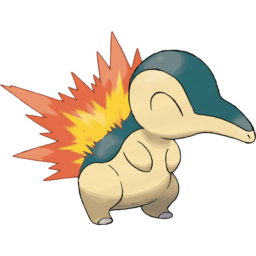

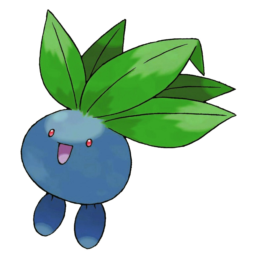

In [13]:
_, val_transform = get_transforms()
hf_dataset = load_dataset('svjack/pokemon-blip-captions-en-ja')
train_split = hf_dataset['train']
full_dataset = HuggingFaceImageDataset(
    train_split,
    transform=val_transform,
    image_column='image'
)
i1, i2 = load_images_from_dataset(full_dataset, 69, 420, target_size=(256, 256))
imshow(tensor_to_image(i1)[...,::-1])
imshow(tensor_to_image(i2)[...,::-1])

In [4]:
def perform_wilcoxon_test(model1_losses, model2_losses):
    """
    Przeprowadza test Wilcoxona dla porównania wyników dwóch modeli.

    Args:
        model1_losses (list): Lista wartości straty dla pierwszego modelu (np. straty walidacyjne z każdej epoki).
        model2_losses (list): Lista wartości straty dla drugiego modelu.

    Returns:
        tuple: Statystyka testowa i p-wartość testu Wilcoxona.
               Zwraca (None, None) jeśli dane są nieodpowiednie.
    """

    if not model1_losses or not model2_losses or len(model1_losses) != len(model2_losses):
        print("Błąd: Listy strat są puste lub mają różną długość. Nie można przeprowadzić testu.")
        return None, None

    print(f"Przeprowadzam test Wilcoxona na {len(model1_losses)} punktach danych.")

    try:
        statistic, p_value = stats.wilcoxon(model1_losses, model2_losses)

        print(f"\nWynik testu Wilcoxona:")
        print(f"Statystyka testowa: {statistic:.4f}")
        print(f"P-wartość: {p_value:.4f}")

        alpha = 0.05
        if p_value < alpha:
            print(f"P-wartość ({p_value:.4f}) jest mniejsza niż poziom istotności ({alpha}).")
            print("Istnieją statystycznie istotne różnice między stratami obu modeli.")
        else:
            print(f"P-wartość ({p_value:.4f}) jest większa lub równa poziomowi istotności ({alpha}).")
            print("Brak statystycznie istotnych różnic między stratami obu modeli.")

        return statistic, p_value

    except ValueError as e:
        print(f"Błąd podczas przeprowadzania testu Wilcoxona: {e}")
        print("Sprawdź, czy dane nie zawierają samych zer lub stałych wartości.")
        return None, None
    except Exception as e:
        print(f"Wystąpił nieoczekiwany błąd: {e}")
        return None, None


try:
    print(f"Ładowanie strat z: {MODEL_ATTENTION_PATH}")
    checkpoint_attention = torch.load(MODEL_ATTENTION_PATH, map_location='cpu')
    losses_attention = checkpoint_attention.get('val_losses', [])
    if not losses_attention:
        print(f"Ostrzeżenie: Nie znaleziono 'val_losses' w checkpoincie {MODEL_ATTENTION_PATH}. Próbuję 'train_losses'.")
        losses_attention = checkpoint_attention.get('train_losses', [])

    print(f"Ładowanie strat z: {MODEL_VAE_PATH}")
    checkpoint_vae = torch.load(MODEL_VAE_PATH, map_location='cpu')
    losses_vae = checkpoint_vae.get('val_losses', [])
    if not losses_vae:
         print(f"Ostrzeżenie: Nie znaleziono 'val_losses' w checkpoincie {MODEL_VAE_PATH}. Próbuję 'train_losses'.")
         losses_vae = checkpoint_vae.get('train_losses', [])

    min_len = min(len(losses_attention), len(losses_vae))
    if min_len == 0:
        print("Błąd: Brak danych o stratach w obu modelach.")
    else:
        losses_attention = losses_attention[:min_len]
        losses_vae = losses_vae[:min_len]

        perform_wilcoxon_test(losses_attention, losses_vae)

except FileNotFoundError as e:
    print(f"Błąd: Nie znaleziono pliku checkpointu - {e}")
    print("Upewnij się, że ścieżki do checkpointów są poprawne.")
except Exception as e:
    print(f"Wystąpił błąd podczas wczytywania danych lub przeprowadzania testu: {e}")


Ładowanie strat z: attention_vae_checkpoint_epoch_400.pth
Ładowanie strat z: vae_checkpoint_epoch_400.pth
Przeprowadzam test Wilcoxona na 400 punktach danych.

Wynik testu Wilcoxona:
Statystyka testowa: 37466.0000
P-wartość: 0.2549
P-wartość (0.2549) jest większa lub równa poziomowi istotności (0.05).
Brak statystycznie istotnych różnic między stratami obu modeli.


In [14]:
def calculate_ms_ssim(image1: torch.Tensor, image2: torch.Tensor):
    """
    Oblicza MS-SSIM między dwoma obrazkami (tensorami Pytorcha).

    Args:
        image1 (torch.Tensor): Pierwszy obrazek (tensor), powinien być w zakresie [0, 1]
                                i mieć kształt (N, C, H, W) lub (C, H, W).
        image2 (torch.Tensor): Drugi obrazek (tensor), jw.

    Returns:
        torch.Tensor: Wartość MS-SSIM.
    """
    if image1.ndim == 3:
        image1 = image1.unsqueeze(0)
    if image2.ndim == 3:
        image2 = image2.unsqueeze(0)

    if image1.device != image2.device:
        image2 = image2.to(image1.device)

    ms_ssim_value = ms_ssim(image1, image2, data_range=1.0)

    return ms_ssim_value

def evaluate_models_on_subset(model_attention, model_vae, dataset, subset_size: int = 400, device: str = 'cpu'):
    """
    Ocenia odwzorowanie dwóch modeli VAE na fragmencie datasetu,
    oblicza L1 loss i przeprowadza test Wilcoxona.

    Args:
        model_attention: Wytrenowany model VAE z attention.
        model_vae: Wytrenowany model VAE bez attention.
        dataset: Obiekt datasetu (np. HuggingFaceImageDataset).
        subset_size: Liczba próbek do oceny.
        device: Urządzenie do obliczeń.
    """
    if subset_size > len(dataset):
        subset_size = len(dataset)
        print(f"Rozmiar subsetu większy niż dataset. Zmieniam na {subset_size}.")

    indices = np.random.choice(len(dataset), subset_size, replace=False)
    print(f"\nRozpoczęcie oceny na fragmencie datasetu ({subset_size} próbek)...")

    model_attention.eval()
    model_vae.eval()

    l1_losses_attention = []
    l1_losses_vae = []

    me_ssim_attention = []
    me_ssim_vae = []

    with torch.no_grad():
        for i, v in enumerate(tqdm(indices, desc="Przetwarzanie subsetu")):
            image, _ = load_images_from_dataset(dataset, int(v), int(v))

            image = image.to(device)

            mu_attention, _ = model_attention.encode(image)
            mu_vae, _ = model_vae.encode(image)

            recon_attention = model_attention.decode(mu_attention)
            recon_vae = model_vae.decode(mu_vae)

            l1_loss_att = F.l1_loss(recon_attention, image, reduction='none').sum(dim=[1, 2, 3])
            l1_losses_attention.extend(l1_loss_att.cpu().tolist())

            l1_loss_vae = F.l1_loss(recon_vae, image, reduction='none').sum(dim=[1, 2, 3])
            l1_losses_vae.extend(l1_loss_vae.cpu().tolist())

            me_ssim_att = calculate_ms_ssim((image+1)/2, (recon_attention+1)/2)
            me_ssim_attention.append(me_ssim_att.item())

            mesim_vae = calculate_ms_ssim((image+1)/2, (recon_vae+1)/2)
            me_ssim_vae.append(mesim_vae.item())


    print("\nObliczono L1 Loss dla obu modeli.")

    if len(l1_losses_attention) < 2 or len(l1_losses_vae) < 2:
        print("Zebrano za mało próbek L1 loss. Upewnij się, że subset_size > 0.")
        return

    perform_wilcoxon_test(l1_losses_attention, l1_losses_vae)
    avg_l1_att = sum(l1_losses_attention) / len(l1_losses_attention)
    avg_l1_vae = sum(l1_losses_vae) / len(l1_losses_vae)
    print(f"Średni L1 Loss (Attention VAE): {avg_l1_att:.4f}")
    print(f"Średni L1 Loss (Standard VAE): {avg_l1_vae:.4f}")

    print("=====================================================")

    perform_wilcoxon_test(me_ssim_attention, me_ssim_vae)
    avg_me_ssim_att = sum(me_ssim_attention) / len(me_ssim_attention)
    avg_me_ssim_vae = sum(me_ssim_vae) / len(me_ssim_vae)
    print(f"Średni MS-SSIM (Attention VAE): {avg_me_ssim_att:.4f}")
    print(f"Średni MS-SSIM (Standard VAE): {avg_me_ssim_vae:.4f}")



SUBSET_SIZE = 400


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")


try:
    print("Wczytywanie modelu VAE z attention...")
    model_attention = load_vae_model(MODEL_ATTENTION_PATH, LATENT_DIM, use_attention=True, device=device)
    print("Model z attention wczytany.")

    print("Wczytywanie modelu VAE bez attention...")
    model_vae = load_vae_model(MODEL_VAE_PATH, LATENT_DIM, use_attention=False, device=device)
    print("Model bez attention wczytany.")

    print("Przygotowanie datasetu...")

    _, val_transform = get_transforms()
    hf_dataset = load_dataset('svjack/pokemon-blip-captions-en-ja')
    train_split = hf_dataset['train']
    full_dataset = HuggingFaceImageDataset(
        train_split,
        transform=val_transform,
        image_column='image'
    )
    print(f"Dataset przygotowany. Całkowity rozmiar: {len(full_dataset)}")

    evaluate_models_on_subset(model_attention, model_vae, full_dataset, subset_size=SUBSET_SIZE, device=device)

except FileNotFoundError as e:
    print(f"Błąd: Nie znaleziono pliku checkpointu - {e}")
    print("Upewnij się, że ścieżki do checkpointów są poprawne.")
except Exception as e:
    print(f"Wystąpił błąd: {e}")
    import traceback
    traceback.print_exc()



Używane urządzenie: cuda
Wczytywanie modelu VAE z attention...
Wykryto checkpoint treningowy
Checkpoint z epoki: 400
Ostatnia strata treningowa: 29787.6272
Ostatnia strata walidacyjna: 29148.0699
Model z attention wczytany.
Wczytywanie modelu VAE bez attention...
Wykryto checkpoint treningowy
Checkpoint z epoki: 400
Ostatnia strata treningowa: 29407.8317
Ostatnia strata walidacyjna: 28558.2652
Model bez attention wczytany.
Przygotowanie datasetu...
Dataset przygotowany. Całkowity rozmiar: 833

Rozpoczęcie oceny na fragmencie datasetu (400 próbek)...


Przetwarzanie subsetu: 100%|█████████████████████████████████████████████████████████| 400/400 [01:01<00:00,  6.53it/s]


Obliczono L1 Loss dla obu modeli.
Przeprowadzam test Wilcoxona na 400 punktach danych.

Wynik testu Wilcoxona:
Statystyka testowa: 18567.0000
P-wartość: 0.0000
P-wartość (0.0000) jest mniejsza niż poziom istotności (0.05).
Istnieją statystycznie istotne różnice między stratami obu modeli.
Średni L1 Loss (Attention VAE): 10319.9182
Średni L1 Loss (Standard VAE): 10804.8613
Przeprowadzam test Wilcoxona na 400 punktach danych.

Wynik testu Wilcoxona:
Statystyka testowa: 35984.0000
P-wartość: 0.0752
P-wartość (0.0752) jest większa lub równa poziomowi istotności (0.05).
Brak statystycznie istotnych różnic między stratami obu modeli.
Średni MS-SSIM (Attention VAE): 0.9689
Średni MS-SSIM (Standard VAE): 0.9692


Używane urządzenie: cuda
Wczytywanie modelu VAE z attention...
Wykryto checkpoint treningowy
Checkpoint z epoki: 400
Ostatnia strata treningowa: 29787.6272
Ostatnia strata walidacyjna: 29148.0699
Model z attention wczytany.
Wczytywanie modelu VAE bez attention...
Wykryto checkpoint treningowy
Checkpoint z epoki: 400
Ostatnia strata treningowa: 29407.8317
Ostatnia strata walidacyjna: 28558.2652
Model bez attention wczytany.
Przygotowanie datasetu walidacyjnego...
Przygotowano 2 obrazków do porównania.
Generowanie rekonstrukcji...
Wyświetlanie porównania...


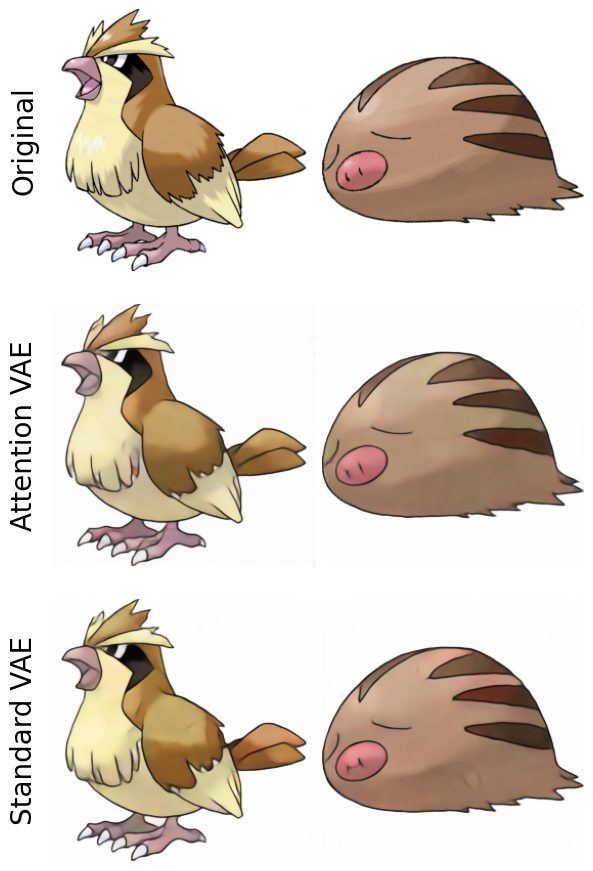

In [30]:
NUM_IMAGES_TO_COMPARE = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

try:
    print("Wczytywanie modelu VAE z attention...")
    model_attention = load_vae_model(MODEL_ATTENTION_PATH, LATENT_DIM, use_attention=True, device=device)
    print("Model z attention wczytany.")

    print("Wczytywanie modelu VAE bez attention...")
    model_vae = load_vae_model(MODEL_VAE_PATH, LATENT_DIM, use_attention=False, device=device)
    print("Model bez attention wczytany.")

    print("Przygotowanie datasetu walidacyjnego...")

    _, val_transform = get_transforms()
    hf_dataset = load_dataset('svjack/pokemon-blip-captions-en-ja')

    train_split = hf_dataset['train']
    full_dataset = HuggingFaceImageDataset(
        train_split,
        transform=val_transform,
        image_column='image'
    )

    if NUM_IMAGES_TO_COMPARE > len(full_dataset):
         print(f"Ostrzeżenie: NUM_IMAGES_TO_COMPARE ({NUM_IMAGES_TO_COMPARE}) większe niż rozmiar datasetu ({len(full_dataset)}). Zmieniam na {len(full_dataset)}.")
         NUM_IMAGES_TO_COMPARE = len(full_dataset)

    comparison_indices = np.random.choice(len(full_dataset), NUM_IMAGES_TO_COMPARE, replace=False).tolist()
    comparison_dataset = torch.utils.data.Subset(full_dataset, comparison_indices)
    comparison_loader = DataLoader(comparison_dataset, batch_size=NUM_IMAGES_TO_COMPARE, shuffle=False, num_workers=0)

    print(f"Przygotowano {NUM_IMAGES_TO_COMPARE} obrazków do porównania.")

    comparison_batch = next(iter(comparison_loader)).to(device)

    model_attention.eval()
    model_vae.eval()

    print("Generowanie rekonstrukcji...")
    with torch.no_grad():
        recon_attention, _, _ = model_attention(comparison_batch)

        recon_vae, _, _ = model_vae(comparison_batch)


    original_display = denormalize_image(comparison_batch).cpu()
    recon_attention_display = denormalize_image(recon_attention).cpu()
    recon_vae_display = denormalize_image(recon_vae).cpu()

    print("Wyświetlanie porównania...")
    fig, axes = plt.subplots(3, NUM_IMAGES_TO_COMPARE, figsize=(NUM_IMAGES_TO_COMPARE * 3, 9))

    if NUM_IMAGES_TO_COMPARE == 1:
      axes = np.array([axes]).T

    for i in range(NUM_IMAGES_TO_COMPARE):
        orig_img = original_display[i].permute(1, 2, 0).numpy()
        orig_img = np.clip(orig_img, 0, 1)
        axes[0, i].imshow(orig_img)
        if i == 0:
            axes[0, i].set_ylabel('Original', fontsize=20)

        axes[0, i].set_yticklabels([])
        axes[0, i].set_xticklabels([])
        for spine in axes[0, i].spines.values():
            spine.set_visible(False)
        axes[0, i].tick_params(left=False, bottom=False, labelleft=True, labelbottom=False)


        recon_att_img = recon_attention_display[i].permute(1, 2, 0).numpy()
        recon_att_img = np.clip(recon_att_img, 0, 1)
        axes[1, i].imshow(recon_att_img)
        if i == 0:
            axes[1, i].set_ylabel('Attention VAE', fontsize=20)

        axes[1, i].set_yticklabels([])
        axes[1, i].set_xticklabels([])
        for spine in axes[1, i].spines.values():
            spine.set_visible(False)
        axes[1, i].tick_params(left=False, bottom=False, labelleft=True, labelbottom=False)


        recon_vae_img = recon_vae_display[i].permute(1, 2, 0).numpy()
        recon_vae_img = np.clip(recon_vae_img, 0, 1)
        axes[2, i].imshow(recon_vae_img)
        if i == 0:
            axes[2, i].set_ylabel('Standard VAE', fontsize=20)
        axes[2, i].tick_params(left=False, bottom=False, labelleft=True, labelbottom=False)

        axes[2, i].set_yticklabels([])
        axes[2, i].set_xticklabels([])
        for spine in axes[2, i].spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"Błąd: Nie znaleziono pliku checkpointu - {e}")
    print("Upewnij się, że ścieżki do checkpointów MODELS_ATTENTION_PATH i MODEL_VAE_PATH są poprawne.")
    print("Może musisz zamontować Google Drive lub skopiować pliki.")
except Exception as e:
    print(f"Wystąpił błąd podczas generowania porównania: {e}")
    traceback.print_exc()



In [15]:
stacks = []

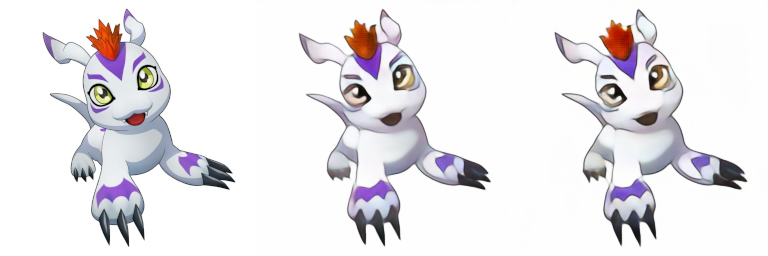

In [16]:
image = load_and_preprocess_image("digimon.png")
image = image.to(device)

with torch.no_grad():
    mu_attention, _ = model_attention.encode(image)
    mu_vae, _ = model_vae.encode(image)

    recon_attention = model_attention.decode(mu_attention)
    recon_vae = model_vae.decode(mu_vae)

    recon_att_img = tensor_to_image(recon_attention)
    recon_vae_img = tensor_to_image(recon_vae)


image_org = Image.open("digimon.png").convert('RGB')
np_img = np.asarray(image_org)[...,::-1]

stack = np.hstack((np_img, recon_att_img, recon_vae_img))
stacks.append(stack)
imshow(stack)

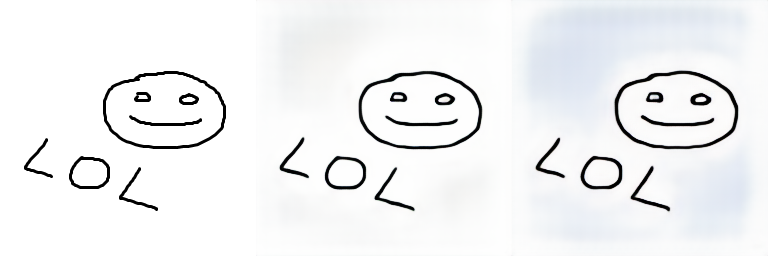

In [17]:
image = load_and_preprocess_image("test.png")
image = image.to(device)

with torch.no_grad():
    mu_attention, _ = model_attention.encode(image)
    mu_vae, _ = model_vae.encode(image)

    recon_attention = model_attention.decode(mu_attention)
    recon_vae = model_vae.decode(mu_vae)

    recon_att_img = tensor_to_image(recon_attention)
    recon_vae_img = tensor_to_image(recon_vae)


image_org = Image.open("test.png").convert('RGB')
np_img = np.asarray(image_org)[...,::-1]

stack = np.hstack((np_img, recon_att_img, recon_vae_img))
stacks.append(stack)
imshow(stack)

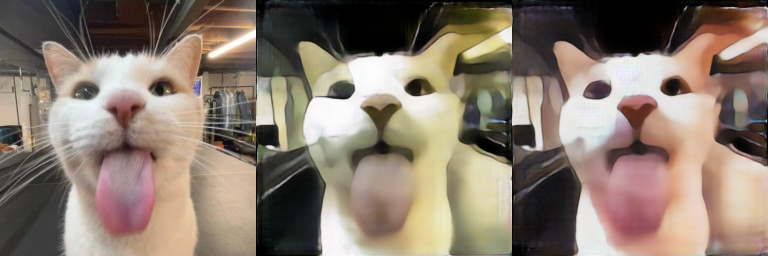

In [18]:
image = load_and_preprocess_image("cat.png")
image = image.to(device)

with torch.no_grad():
    mu_attention, _ = model_attention.encode(image)
    mu_vae, _ = model_vae.encode(image)

    recon_attention = model_attention.decode(mu_attention)
    recon_vae = model_vae.decode(mu_vae)

    recon_att_img = tensor_to_image(recon_attention)
    recon_vae_img = tensor_to_image(recon_vae)


image_org = Image.open("cat.png").convert('RGB')
np_img = np.asarray(image_org)[...,::-1]


stack = np.hstack((np_img, recon_att_img, recon_vae_img))
stacks.append(stack)
imshow(stack)

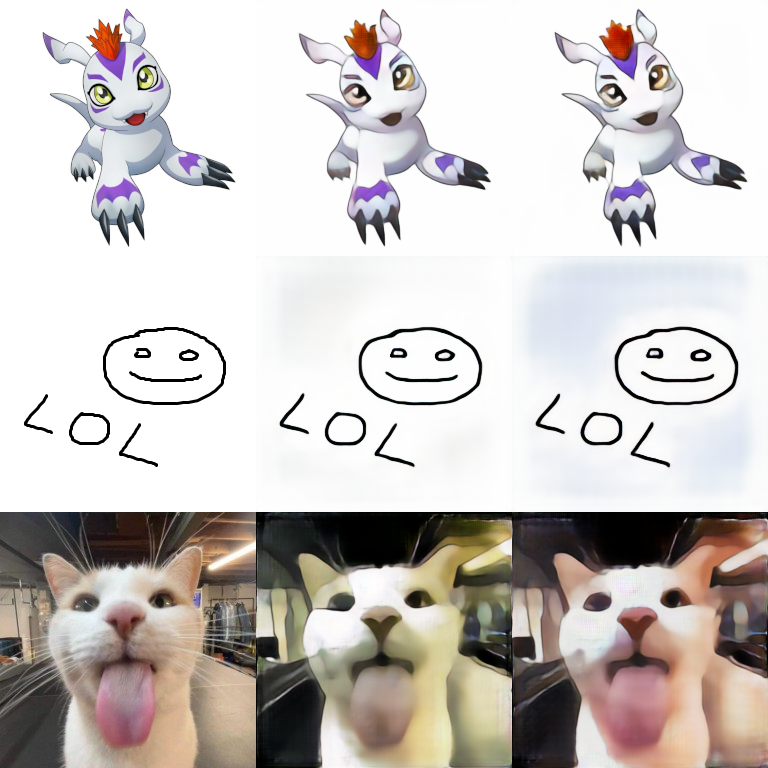

In [19]:
imshow(np.vstack(stacks))